<a href="https://colab.research.google.com/github/mwooll/ElTony/blob/main/data_vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install chart-studio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from plotly import tools
from chart_studio import plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
from PIL import Image
init_notebook_mode(connected=True)

plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

# Data Preprocessing

In [51]:
# Load the dataset
unprocessed = pd.read_csv('data/pokemon.csv')

image_folder = 'poke_images/'

In [62]:
unprocessed.columns

Index(['Number', 'Name', 'Type_1', 'Type_2', 'Total', 'HP', 'Attack',
       'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Generation', 'isLegendary',
       'Color', 'hasGender', 'Pr_Male', 'Egg_Group_1', 'Egg_Group_2',
       'hasMegaEvolution', 'Height_m', 'Weight_kg', 'Catch_Rate',
       'Body_Style'],
      dtype='object')

In [67]:
unprocessed[unprocessed.columns[:14]].head()

,Number,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,Green
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,Green
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,Green
3,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,Red
4,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False,Red


In [68]:
unprocessed[unprocessed.columns[14:]].head()

,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,True,0.875,Monster,Grass,False,0.71,6.9,45,quadruped
1,True,0.875,Monster,Grass,False,0.99,13.0,45,quadruped
2,True,0.875,Monster,Grass,True,2.01,100.0,45,quadruped
3,True,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed
4,True,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed


## Classification of Attributes

In [69]:
# 0. PokéDex number
print("The dataset contains the PokéDex number (named just 'Number') of every Pokémon, which is an ordinal variable.")
print("We will use it as index.")
indexed = unprocessed.set_index(keys="Number", drop=True)

The dataset contains the PokéDex number (named just 'Number') of every Pokémon, which is an ordinal variable.
We will use it as index.


In [70]:
# 1. core_col are the attributes which determine if a Pokémon is a good choice for a team
core_col = ["Type_1", "Type_2", 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed']

print("Type_1 and Type_2 are categorical with 18 values for Type_1 (there are 18 different types).")
print("Type_2 has 19 categories since it can also be None/NaN, which makes semantically sense, \
so we won't be dropping this column.")
print("HP, Attack, Defense, Sp_Atk, Sp_Def and Speed are positive integers, i.e., discrete quantitative attributes.")

Type_1 and Type_2 are categorical with 18 values for Type_1 (there are 18 different types).
Type_2 has 19 categories since it can also be None/NaN, which makes semantically sense, so we won't be dropping this column.
HP, Attack, Defense, Sp_Atk, Sp_Def and Speed are positive integers, i.e., discrete quantitative attributes.


In [83]:
# 2. filt_col are the attributes most useful for filtering and searching apart from core_col
filt_col = ["Name", "Generation", "isLegendary", "Color", "Body_Style"]
print("Name is a nominal variable and is next to the PokéDex number the only attribute with a unique value per datapoint.")
print("Generation is an ordinal attribute with values from 1 to 6.")
print("isLegendary is a boolean attribute.")
print(f"Color and Body_Style are both categorical, with {len(unprocessed.Color.unique())} \
and {len(unprocessed.Body_Style.unique())} categories respectively.")

Name is a nominal variable and is next to the PokéDex number the only attribute with a unique value per datapoint.
Generation is an ordinal attribute with values from 1 to 6.
isLegendary is a boolean attribute.
Color and Body_Style are both categorical, with 10 and 14 categories respectively.


In [79]:
# 3. other_col are the attributes we will most likely not need at all
other_col = ["hasGender", "Pr_Male", "Egg_Group_1", "Egg_Group_2", "Catch_Rate", "hasMegaEvolution", "Height_m", "Weight_kg"]
print(f"Most likely, we will not use the columns: {other_col}, but if we end up using one or two, than only as filter options.")
print("hasGender and hasMegaEvolution are boolean attributes.")
print(f"Egg_Group_1 and Egg_Group_2 are nominal attrbiutes, with {len(unprocessed.Egg_Group_1.unique())} \
and {len(unprocessed.Egg_Group_2.unique())} categories respectively.")
print("Pr_Male, Catch_Rate, Height_m and Weight_kg are quantitative attributes.")

Most likely, we will not use the columns: ['hasGender', 'Pr_Male', 'Egg_Group_1', 'Egg_Group_2', 'Catch_Rate', 'hasMegaEvolution', 'Height_m', 'Weight_kg'], but if we end up using one or two, than only as filter options.
hasGender and hasMegaEvolution are boolean attributes.
Egg_Group_1 and Egg_Group_2 are nominal attrbiutes, with 15 and 14 categories respectively.
Pr_Male, Catch_Rate, Height_m and Weight_kg are quantitative attributes.


## Cleaned Dataset

In [84]:
# deleting columns that we do not need
pokedata = indexed.drop(columns=other_col)
pokedata.head()

,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,Body_Style
Number,,,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,Green,quadruped
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,Green,quadruped
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,Green,quadruped
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,Red,bipedal_tailed
5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False,Red,bipedal_tailed


### Checking for null values in the attributes we focus on

In [98]:
# Type_2 is the only column where NaN is allowed
pokedata.isna().any()

Name           False
Type_1         False
Type_2          True
Total          False
HP             False
Attack         False
Defense        False
Sp_Atk         False
Sp_Def         False
Speed          False
Generation     False
isLegendary    False
Color          False
Body_Style     False
dtype: bool

## Visualization to get familiar with the Dataset

### Distribution of HP

In [105]:
fig = ff.create_distplot([pokedata.HP], ['HP'], bin_size=5)
fig.update_layout(title="Distribution of HP") 
iplot(fig, filename='Basic Distplot')

### Distributions of Attack and Defense

In [108]:
hist_data = [pokedata['Attack'], pokedata['Defense']]
group_labels = ['Attack', 'Defense']
fig = ff.create_distplot(hist_data, group_labels, bin_size=5)
fig.update_layout(title="Distribution of Attack and Defense") 
iplot(fig, filename='Distplot of attack and defense')

### Distribution of all Stats

In [112]:
trace0 = go.Box(y=pokedata["HP"], name="HP")
trace1 = go.Box(y=pokedata["Attack"], name="Attack")
trace2 = go.Box(y=pokedata["Defense"], name="Defense")
trace3 = go.Box(y=pokedata["Sp_Atk"], name="Sp_Atk")
trace4 = go.Box(y=pokedata["Sp_Def"], name="Sp_Def")
trace5 = go.Box(y=pokedata["Speed"], name="Speed")
data = [trace0, trace1, trace2,trace3, trace4, trace5]
layout = {"title": "Pokémon Base Stats Boxplots"}
fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Scatterplot for Type combinations

In [126]:
data = go.Scatter(x=pokedata["Type_1"], y=pokedata["Type_2"],
                  marker={"symbol": "circle", "size": 10}, line={"width": 0})
fig = go.Figure(data=data, layout=layout)
fig.show()

# Spider maps for the visualization tool

 ### Visualize the sats of a single Pokémon


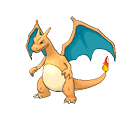

In [9]:
# Lowercase the names of Pokemon for matching image names
pokedata["Name"] = pokedata["Name"].str.lower()

pokemon_name = "charizard"

pokemon_image_path = image_folder+pokemon_name+'.png'

x = pokedata[pokedata["Name"] == pokemon_name]

data = [go.Scatterpolar(
  r = [x['HP'].values[0],x['Attack'].values[0],x['Defense'].values[0],x['Sp_Atk'].values[0],x['Sp_Def'].values[0],x['Speed'].values[0],x["HP"].values[0]],
  theta = ['HP','Attack','Defense','Sp_Atk','Sp_Def','Speed','HP'],
  fill = 'toself',
     line =  dict(
            color = 'orange'
        )
)]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 200]
    )
  ),
  showlegend = False,
  title = "{} stats distribution".format(x.Name.values[0])
)

# Load the image using PIL
img = Image.open(pokemon_image_path)

# Add image to the layout
layout.images = [dict(
    source=img,
    x=0.85,
    y=0.5,
    xref="paper",
    yref="paper",
    sizex=0.7,
    sizey=0.7,
    xanchor="center",
    yanchor="middle"
)]

fig = go.Figure(data=data, layout=layout)
fig.show()

### Visualize the sats of the fastest Pokémon


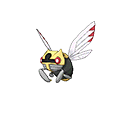

In [10]:
pokemon_name = pokedata['Name'].loc[[pokedata['Speed'].idxmax()]].values[0]

pokemon_image_path = image_folder+pokemon_name+'.png'

x = pokedata.loc[[pokedata['Speed'].idxmax()]]

data = [go.Scatterpolar(
  r = [x['HP'].values[0],x['Attack'].values[0],x['Defense'].values[0],x['Sp_Atk'].values[0],x['Sp_Def'].values[0],x['Speed'].values[0],x["HP"].values[0]],
  theta = ['HP','Attack','Defense','Sp_Atk','Sp_Def','Speed','HP'],
  fill = 'toself',
     line =  dict(
            color = 'darkkhaki'
        )
)]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 200]
    )
  ),
  showlegend = False,
  title = "{} stats distribution".format(x.Name.values[0])
)

# Load the image
img = Image.open(pokemon_image_path)

# Add image to the layout
layout.images = [dict(
    source=img,
    x=0.85,
    y=0.5,
    xref="paper",
    yref="paper",
    sizex=0.7,
    sizey=0.7,
    xanchor="center",
    yanchor="middle"
)]

fig = go.Figure(data=data, layout=layout)
fig.show()

### Comparison of two Pokémon's stats


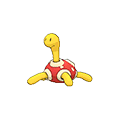
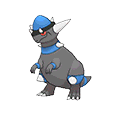

In [11]:
pokemon_name_a = pokedata['Name'].loc[[pokedata['Attack'].idxmax()]].values[0]
pokemon_name_b = pokedata['Name'].loc[[pokedata['Defense'].idxmax()]].values[0]

pokemon_image_path_a = image_folder+pokemon_name_a+'.png'
pokemon_image_path_b = image_folder+pokemon_name_b+'.png'

a = pokedata.loc[[pokedata['Attack'].idxmax()]]
b = pokedata.loc[[pokedata['Defense'].idxmax()]]


data = [
    go.Scatterpolar(
        name = a.Name.values[0],
        r = [a['HP'].values[0],a['Attack'].values[0],a['Defense'].values[0],a['Sp_Atk'].values[0],a['Sp_Def'].values[0],a['Speed'].values[0],a["HP"].values[0]],
        theta = ['HP','Attack','Defense','Sp_Atk','Sp_Def','Speed','HP'],
        fill = 'toself',
        line =  dict(
                color = 'cyan'
            )
        ),
    go.Scatterpolar(
            name = b.Name.values[0],
            r = [b['HP'].values[0],b['Attack'].values[0],b['Defense'].values[0],b['Sp_Atk'].values[0],b['Sp_Def'].values[0],b['Speed'].values[0],b["HP"].values[0]],
            theta = ['HP','Attack','Defense','Sp_Atk','Sp_Def','Speed','HP'],
            fill = 'toself',
            line =  dict(
                color = 'orange'
            )
        )]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 200]
    )
  ),
  showlegend = True,
  title = "{} vs {} Stats Comparison".format(a.Name.values[0], b.Name.values[0])
)

# Load the image
img_a = Image.open(pokemon_image_path_a)
img_b = Image.open(pokemon_image_path_b)

# Add image to the layout
layout.images = [dict(
    source=img_b,
    x=0.85,
    y=0.5,
    xref="paper",
    yref="paper",
    sizex=0.7,
    sizey=0.7,
    xanchor="center",
    yanchor="middle"),
    dict(
        source=img_a,
        x= 0.15,
        y=0.5,
        xref="paper",
        yref="paper",
        sizex=0.7,
        sizey=0.7,
        xanchor="center",
        yanchor="middle"
    )]

fig = go.Figure(data=data, layout=layout)
fig.show()
